In [196]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb  1 16:01:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |  15965MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [197]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 7.84 s (started: 2022-02-01 16:01:06 +00:00)


In [198]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 3.56 ms (started: 2022-02-01 16:01:14 +00:00)


In [199]:
!pip install --quiet optuna

time: 3.61 s (started: 2022-02-01 16:01:14 +00:00)


In [200]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

import optuna # hyeperparam optimization 

time: 14.5 ms (started: 2022-02-01 16:01:17 +00:00)


# Variables

## Paths

In [201]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220201_16H01/
time: 10.3 ms (started: 2022-02-01 16:01:17 +00:00)


## Other

In [202]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = None # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 25
# learing rate 
# learning_rate = 0.001 # a learning rate of 0.001 is often used / working
# batch size 
batch_size = 32 #32
# base model trainable 
base_model_trainable = False

# number of trials optuna
n_trials = 25 

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 16.3 ms (started: 2022-02-01 16:01:17 +00:00)


# Load & filter data

## Unzip images

In [203]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 5.94 ms (started: 2022-02-01 16:01:17 +00:00)


In [204]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 2.61 ms (started: 2022-02-01 16:01:17 +00:00)


## File_path df

In [205]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


215410 rows in the file


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 2.58 s (started: 2022-02-01 16:01:17 +00:00)


In [206]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 4.01 ms (started: 2022-02-01 16:01:20 +00:00)


In [207]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 379 ms (started: 2022-02-01 16:01:20 +00:00)


In [208]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 178 ms (started: 2022-02-01 16:01:20 +00:00)


In [209]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 58.1 ms (started: 2022-02-01 16:01:21 +00:00)


In [210]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 54.8 ms (started: 2022-02-01 16:01:21 +00:00)


In [211]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 74.6 ms (started: 2022-02-01 16:01:21 +00:00)


In [212]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 59.4 ms (started: 2022-02-01 16:01:21 +00:00)


In [213]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 74.2 ms (started: 2022-02-01 16:01:21 +00:00)


In [214]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 1.37 ms (started: 2022-02-01 16:01:21 +00:00)


In [215]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

time: 2.34 ms (started: 2022-02-01 16:01:21 +00:00)


In [216]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 30 ms (started: 2022-02-01 16:01:21 +00:00)


In [217]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
5,/content/RAW DATA/IMAGES/2006/Agaricus/682.jpg,Agaricaceae,0
6,/content/RAW DATA/IMAGES/2006/Agaricus/685.jpg,Agaricaceae,0
7,/content/RAW DATA/IMAGES/2006/Agaricus albolut...,Agaricaceae,0
8,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0
9,/content/RAW DATA/IMAGES/2006/Agaricus augustu...,Agaricaceae,0


time: 85.5 ms (started: 2022-02-01 16:01:21 +00:00)


In [218]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 2.49 ms (started: 2022-02-01 16:01:21 +00:00)


In [219]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 35787


,label,gbif_info.family,size
0,0,Agaricaceae,5254
1,1,Strophariaceae,4494
2,2,Amanitaceae,4769
3,3,Boletaceae,6060
4,4,Tricholomataceae,4967
5,5,Cortinariaceae,4124
6,6,Russulaceae,6119


time: 40.4 ms (started: 2022-02-01 16:01:21 +00:00)


In [220]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Agaricaceae',
 '1': 'Strophariaceae',
 '2': 'Amanitaceae',
 '3': 'Boletaceae',
 '4': 'Tricholomataceae',
 '5': 'Cortinariaceae',
 '6': 'Russulaceae'}

time: 5.48 ms (started: 2022-02-01 16:01:21 +00:00)


## Train/test split

In [221]:
#train/test 
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
print(df_train.shape,df_test.shape)

(28629, 3) (7158, 3)
time: 55.5 ms (started: 2022-02-01 16:01:21 +00:00)


In [222]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 35.6 ms (started: 2022-02-01 16:01:21 +00:00)


### Plot few images

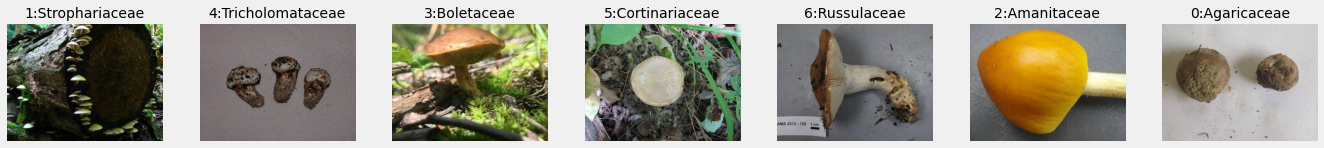

time: 440 ms (started: 2022-02-01 16:01:21 +00:00)


In [223]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

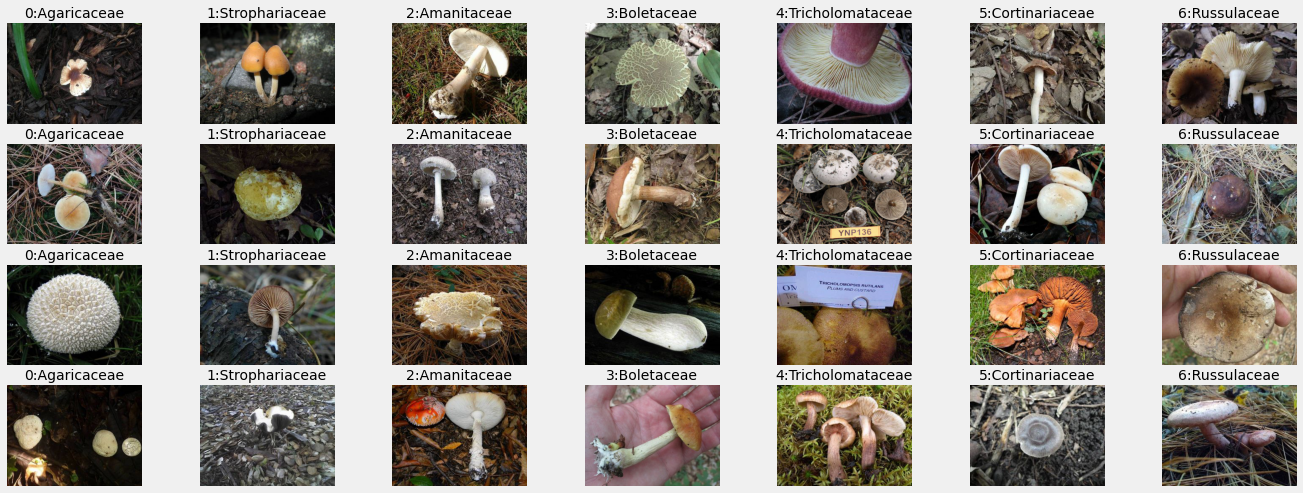

time: 1.72 s (started: 2022-02-01 16:01:22 +00:00)


In [224]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Tensorflow

## Data generator

In [225]:
# train 
train_data_generator = ImageDataGenerator(
                                            # rotation_range=90,
                                            # width_shift_range=0.2,
                                            # height_shift_range=0.2,
                                            # shear_range=0.2,
                                            # zoom_range=0.2,
                                            # horizontal_flip=True,
                                            # vertical_flip=True,
                                            # fill_mode='nearest',
                                          ) 

train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train, 
                                                           x_col = "drive_file_path",y_col="label", 
                                                           target_size=resol,
                                                           batch_size=batch_size, 
                                                           class_mode='sparse')


Found 28629 validated image filenames belonging to 7 classes.
time: 3.07 s (started: 2022-02-01 16:01:24 +00:00)


In [226]:
#test 
test_data_generator = ImageDataGenerator()
test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test,
                                                         x_col = "drive_file_path",y_col="label", 
                                                           target_size=resol,
                                                           batch_size=batch_size, 
                                                           class_mode='sparse')


Found 7158 validated image filenames belonging to 7 classes.
time: 78.6 ms (started: 2022-02-01 16:01:27 +00:00)


## Callbacks

In [227]:
early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=3, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.01,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 5.49 ms (started: 2022-02-01 16:01:27 +00:00)


# Fonctions

In [228]:
def plot_history(history,pathinfos):
  # train_acc_model = history.history['accuracy']
  # val_acc_model = history.history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history.history['loss'])), history.history['loss'], '-o', label = "training")
  plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 21.8 ms (started: 2022-02-01 16:01:27 +00:00)


# Best model fit

## Dict of model param found in previous notebook

In [229]:
model_dict = {
    'EFB1' : tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'EFB0' : tf.keras.applications.EfficientNetB0(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV3Large': tf.keras.applications.MobileNetV3Large(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
}

time: 11.1 s (started: 2022-02-01 16:01:27 +00:00)


In [233]:
model_param_dir = {
    'EFB1' : '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Optuna for DL classifier optimization/220201_09H39_EFB1/',
    'EFB0' : '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Optuna for DL classifier optimization/220201_11H44_EFB0/',
    'MobileNetV3Large': '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Optuna for DL classifier optimization/220201_11H44_MobileNetV3Large/',
}

time: 1.63 ms (started: 2022-02-01 16:02:29 +00:00)


# choose model 

In [234]:
# define model 
model_name  = 'MobileNetV3Large'
base_model = model_dict[model_name]

time: 1.63 ms (started: 2022-02-01 16:02:31 +00:00)


In [235]:
# get best param from optuna study 
optuna_trials_path = model_param_dir[model_name] + 'optuna_trials.csv'
optuna_trials_df = pd.read_csv(optuna_trials_path, index_col= 'number' )
best_trial = optuna_trials_df[optuna_trials_df['value'] == optuna_trials_df['value'].max()]
best_trial = best_trial.iloc[0].to_dict()
best_trial 

{'Unnamed: 0': 11,
 'datetime_complete': '2022-02-01 12:51:28.202502',
 'datetime_start': '2022-02-01 12:48:32.197446',
 'duration': '0 days 00:02:56.005056',
 'params_dropout_rate_0': 0.30000000000000004,
 'params_dropout_rate_1': 0.35000000000000003,
 'params_dropout_rate_2': 0.0,
 'params_dropout_rate_3': 0.0,
 'params_dropout_rate_4': nan,
 'params_last_layer_trainable': False,
 'params_lr': 0.00016163917934955145,
 'params_num_filters_0': 2048,
 'params_num_filters_1': 1024,
 'params_num_filters_2': 1024.0,
 'params_num_filters_3': 2048.0,
 'params_num_filters_4': nan,
 'params_num_layer': 4,
 'state': 'COMPLETE',
 'value': 0.6189516186714172}

time: 418 ms (started: 2022-02-01 16:02:31 +00:00)


In [236]:
# extract param only 
best_trial_param  = {} 
for k,v in best_trial.items():
  if 'params_' in k and np.isnan(v)==False:
    best_trial_param[k.replace('params_','')] = v
best_trial_param

{'dropout_rate_0': 0.30000000000000004,
 'dropout_rate_1': 0.35000000000000003,
 'dropout_rate_2': 0.0,
 'dropout_rate_3': 0.0,
 'last_layer_trainable': False,
 'lr': 0.00016163917934955145,
 'num_filters_0': 2048,
 'num_filters_1': 1024,
 'num_filters_2': 1024.0,
 'num_filters_3': 2048.0,
 'num_layer': 4}

time: 7.25 ms (started: 2022-02-01 16:02:37 +00:00)


In [237]:
# DEFINE BEST MODEL Param
num_layer = best_trial_param['num_layer']
lr = best_trial_param['lr']
last_layer_trainable= best_trial_param['last_layer_trainable']
layer_units, layer_dropouts = {}, {}
for k,v in best_trial_param.items():
  if 'num_filters' in k:
    layer_units[int(k[-1:])] = v
  if 'dropout_rate' in k:
    layer_dropouts[int(k[-1:])] = v


time: 3.68 ms (started: 2022-02-01 16:02:37 +00:00)


In [238]:
# construct model 
# base + average 
layers = [base_model,tf.keras.layers.GlobalAveragePooling2D()] 
# dense + dropout 
for i in range(num_layer):
      layers.append(tf.keras.layers.Dense(units =layer_units[i], activation = 'relu'))
      layers.append(tf.keras.layers.Dropout(layer_dropouts[i]))
# prediction 
layers.append(Dense(units = classes_count, activation = 'softmax'))
#freeze/unfreeze all layers 
for layer in base_model.layers:
    layer.trainable = base_model_trainable
# just the last layer
base_model.layers[-1:][0].trainable = True if last_layer_trainable == 'True' else False
#create model 
model = tf.keras.Sequential(layers,name = model_name)
model.summary()

Model: "MobileNetV3Large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 2048)              2623488   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_7 (Dropout)         (None, 1024)         

In [239]:
# compilation 
optimizer =  'Adam'
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
# Entraînement
tic = time.time() # timer start
training_history_model = model.fit(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch = len(df_train)//batch_size,
                                  validation_data = test_generator,
                                  validation_steps = len(df_test)//batch_size,
                                   class_weight=class_weights,
                                  callbacks=[
                                             early_stopping,reduce_learning_rate
                                             ])
# timer end 
tac = time.time()
time_to_fit = tic - tac

Epoch 1/25
894/894 [==============================] - 155s 169ms/step - loss: 1.2457 - accuracy: 0.5470 - val_loss: 1.0171 - val_accuracy: 0.6236 - lr: 1.6164e-04
Epoch 2/25
894/894 [==============================] - 151s 169ms/step - loss: 1.0083 - accuracy: 0.6394 - val_loss: 0.9780 - val_accuracy: 0.6394 - lr: 1.6164e-04
Epoch 3/25
894/894 [==============================] - 146s 164ms/step - loss: 0.8757 - accuracy: 0.6895 - val_loss: 0.9793 - val_accuracy: 0.6481 - lr: 1.6164e-04
Epoch 4/25
894/894 [==============================] - 144s 161ms/step - loss: 0.7592 - accuracy: 0.7302 - val_loss: 0.9401 - val_accuracy: 0.6675 - lr: 1.6164e-04
Epoch 5/25
894/894 [==============================] - 147s 165ms/step - loss: 0.6441 - accuracy: 0.7714 - val_loss: 1.0098 - val_accuracy: 0.6537 - lr: 1.6164e-04
Epoch 6/25
894/894 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.8045
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.616391818970442e-06.
894/894 [

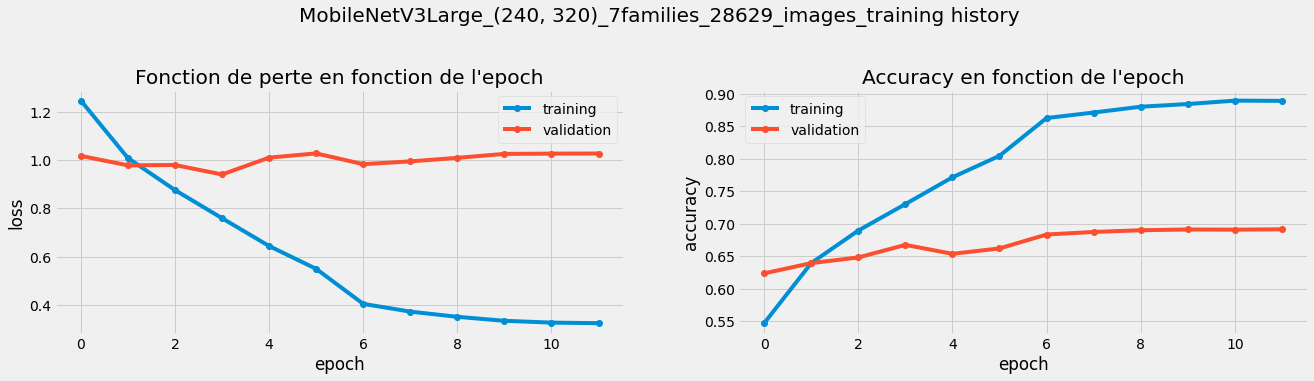

time: 742 ms (started: 2022-02-01 16:37:59 +00:00)


In [240]:
# csv start path infos 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
# export summary model & param 
with open(export_dir + pathinfos  +  '_modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
pd.DataFrame.from_dict(best_trial_param, orient = 'index').to_csv(export_dir + pathinfos  +  '_modelparam.csv')
# save  & export history 
hist_df = pd.DataFrame(training_history_model.history)
hist_df.to_csv(export_dir + pathinfos + '_best_model_history.csv')
training_history_fig = plot_history(training_history_model,pathinfos)
display(training_history_fig)

# Assess

## Fonctions

In [241]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 53.4 ms (started: 2022-02-01 16:37:59 +00:00)


##  Plots

In [242]:
# define X test 
X_test_path = df_test['drive_file_path']
X_test = []
for filepath in tqdm(X_test_path):
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    # Redimensionnement
    im = tf.image.resize(im, size=resol)
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)
# predict y_test
y_prob = model.predict(X_test, batch_size=16)
test_pred_class = tf.argmax(y_prob, axis = 1).numpy()
y_test_class= df_test['label'].astype(int) 
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + pathinfos + '_classification report.csv'
report.to_csv(report_path)

100%|██████████| 7158/7158 [00:21<00:00, 336.13it/s]


              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1051
           1       0.63      0.65      0.64       899
           2       0.76      0.77      0.76       954
           3       0.81      0.83      0.82      1212
           4       0.59      0.57      0.58       993
           5       0.56      0.60      0.58       825
           6       0.71      0.69      0.70      1224

    accuracy                           0.69      7158
   macro avg       0.68      0.68      0.68      7158
weighted avg       0.69      0.69      0.69      7158

time: 37.2 s (started: 2022-02-01 16:37:59 +00:00)


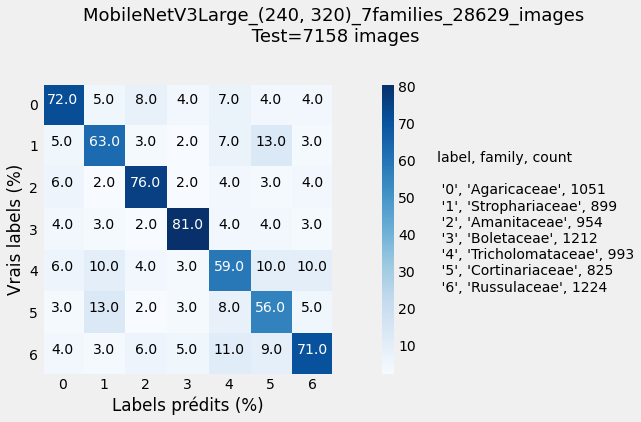

time: 718 ms (started: 2022-02-01 16:38:37 +00:00)


In [243]:
# conf matrix  
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')

In [247]:
training_epochs = len(training_history_model.history['loss'])
maxacc = round(max(training_history_model.history['accuracy']),2)
maxvalacc = round(max(training_history_model.history['val_accuracy']),2)
fit_time = -round(time_to_fit/60,1)
results_folder = os.path.basename(os.path.dirname(export_dir))
print('train/val acc={}/{} in {} epochs in {} minutes with model {} in folder {}'.format(maxacc,maxvalacc,training_epochs,fit_time,model.name,results_folder))

train/val acc=0.89/0.69 in 12 epochs in 35.3 minutes with model MobileNetV3Large in folder 220201_16H01
time: 4.68 ms (started: 2022-02-01 16:40:12 +00:00)


In [245]:
pathinfos

'MobileNetV3Large_(240, 320)_7families_28629_images'

time: 3.57 ms (started: 2022-02-01 16:38:37 +00:00)


# Experiments
* EFB1_(240, 320)_7families_28629_images:
  * train/val acc=0.83/0.69 in 10 epochs in 21.9 minutes with model EFB1 in folder 220201_14H48
  * Increase to 25 epochs mais early stop:
    * train/val acc=0.75/0.67 in 9 epochs in 24.7 minutes with model EFB1 in folder 220201_15H18


* MobileNetV3Large_(240, 320)_7families_28629_images
  * train/val acc=0.89/0.69 in 12 epochs in 35.3 minutes with model MobileNetV3Large in folder 220201_16H01






# TO DO
* random selct plot tf + train : 1 image per class
  * https://support.datascientest.com/t/8-retrouver-image-dans-le-tf-dataset/4033/4
* try to add datagen in optuna objective function (avce trial.suggest_categorical("lambda", [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]) for boolean
* Try to add FRUIT360 ?

In [246]:
# !kill -9 -1

time: 1.16 ms (started: 2022-02-01 16:38:37 +00:00)
